### Library

---






In [ ]:
from google.colab import files 
from tensorflow.keras.callbacks import LambdaCallback
from collections import Counter
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from tqdm.notebook import tqdm_notebook as tqdm_

from tensorflow.keras.utils import to_categorical, plot_model as pm
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,\
         Dropout, BatchNormalization, Input, concatenate, Conv2DTranspose, \
         Embedding, Conv1D, Conv1DTranspose, MaxPooling1D, SpatialDropout1D
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 


from tensorflow.keras.models import load_model
import seaborn as sns
sns.set_style('darkgrid')

class CallBacK():
  
  def on_train_begin(self, logs):

    print('\u001b[36m','========= Education =========',  '\u001b[0m')
    print('------------------------------')
    self.curr = {}
    self.best_val = 0
    self.path = '/content/best_model_2.h5'

    self.hs = {}
    self.hs['loss'] = []
    self.hs['val_loss'] = []
    self.hs['accuracy'] = []
    self.hs['val_accuracy'] = []


  def on_epoch_end(self, epoch, logs):

    self.hs['loss'].append(logs['loss'])
    self.hs['val_loss'].append(logs['val_loss'])
    self.hs['accuracy'].append(logs['accuracy'])
    self.hs['val_accuracy'].append(logs['val_accuracy'])
    self.curr_val = round(logs['val_accuracy'], 4)
    self.curr[epoch] = self.curr_val

    if self.best_val < self.curr_val:
      self.best_val = self.curr_val
      model.save(self.path)

  def on_train_end(self, logs):
    global model
    model = load_model(self.path)

    for key, val in self.curr.items():
      if val == max(self.curr.values()):
        print('\u001b[44m', '\u001b[37;1m', 'epoch: {} val_acc: {}'.format(key+1,val), '\u001b[0m')
      else:
        print('epoch: {} val_accuracy: {} '.format(key+1,val))
    print('-------------------------------')
    print('\u001b[36m', '====== Training completed ====', '\u001b[0m')
    print('===============================')

    plt.figure(2, figsize=(16,5))

    plt.subplot(121) # 1 строка 2 столбца 1 график
    plt.title('Accuracy', fontsize=18, color='grey')
    plt.plot(self.hs['accuracy'], label='accuracy', c='blue')
    plt.plot(self.hs['val_accuracy'], label='val_accuracy', c='red')
    plt.ylabel('% accuracy', fontsize = 13, color = 'grey')
    plt.xlabel('epoch', fontsize = 13, color = 'grey')
    plt.legend()

    plt.subplot(122) # 1 строка 2 столбца 2 график
    plt.title('Loss', fontsize=18, color='grey')
    plt.plot(self.hs['loss'], label='loss', c='blue')
    plt.plot(self.hs['val_loss'], label='val_loss', c='red')
    plt.ylabel('error', fontsize = 13, color = 'grey')
    plt.xlabel('epoch', fontsize = 13, color = 'grey')
    plt.legend()
    plt.show()


CaLL = CallBacK()

lamCB = LambdaCallback(on_train_begin = CaLL.on_train_begin,
                       on_epoch_end = CaLL.on_epoch_end,
                       on_train_end = CaLL.on_train_end)



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences 

a = np.array([[1,2,3], [1,2,3,4,5], [1,2]], dtype=object)
pad_sequences(a, maxlen=5)

array([[0, 0, 1, 2, 3],
       [1, 2, 3, 4, 5],
       [0, 0, 0, 1, 2]], dtype=int32)

### Подготовка данных (Тексты писателей)

---



In [ ]:
path_writers = '/content/drive/MyDrive/Тексты писателей' # тексты писателей
path_appeal = '/content/drive/MyDrive/clean_data.csv' # обращение граждан

In [ ]:
!cp -r '/content/drive/MyDrive/Тексты писателей' '/content/writers'

def read_text(fileName):
  with open(fileName, 'r') as f:
    text = f.read()
    text = text.replace('\n', ' ')
    text = text.replace('\ufeff', '')
    text = text.replace('  ', ' ')
    text = text.replace('   ', ' ')
    text = text.replace('    ', ' ')
    text = text.replace('     ', ' ')
    text = text.replace('-', ' ')
    return text

ClassName = [(i.split(')')[0][1:]) for i in os.listdir('writers')]
ClassName = list(set(ClassName))
nClasses = len(ClassName)
print('Классы:',ClassName)
print('Длина:',nClasses)

train_text = []
test_text = []

train_text = [read_text('/content/writers/'+j) for i in ClassName \
              for j in os.listdir('writers') if ('Обучающая' in j and i in j)]
test_text = [read_text('/content/writers/'+j) for i in ClassName \
             for j in os.listdir('writers') if ('Тестовая' in j and i in j)]

Классы: ['Макс Фрай', 'Клиффорд_Саймак', 'Булгаков', 'О. Генри', 'Рэй Брэдберри', 'Стругацкие']
Длина: 6


In [ ]:
def Writers():
  total_w = [len(train_text[i].split(' ')) for i in range(6)]
  x = ClassName
  y = total_w
  plt.figure(figsize=(14,5))
  plt.bar(x, y, align='center')
  plt.title('Писатели')
  plt.show()

### Tokenizer

---



In [ ]:
MW = 15000
tokenizer = Tokenizer(MW, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(train_text)
TrainWordIndexes = tokenizer.texts_to_sequences(train_text)
TestWordIndexes = tokenizer.texts_to_sequences(test_text)  

In [ ]:
def revers(text):
  return text[::-1]
  
show_test = train_text[2].split(' ')
print(show_test[:10])
print(TrainWordIndexes[2][:10])

['Белая', 'гвардия', '', 'Посвящается[1]', 'Любови', 'Евгеньевне', 'Белозерской[2]', 'Пошел', 'мелкий', 'снег']
[2959, 5550, 1, 1507, 1, 1, 1, 1518, 355, 8569]


In [ ]:
for i in range(6):
  print(ClassName[i], len(TrainWordIndexes[i]))

Макс Фрай 568533
Клиффорд_Саймак 251502
Булгаков 261465
О. Генри 160607
Рэй Брэдберри 214454
Стругацкие 313012


In [ ]:
for i in range(6):
  R_twi = revers(TrainWordIndexes[i])
  TrainWordIndexes[i] = TrainWordIndexes[i] + R_twi
for i in range(6):
  print(ClassName[i], len(TrainWordIndexes[i]))

Макс Фрай 1137066
Клиффорд_Саймак 503004
Булгаков 522930
О. Генри 321214
Рэй Брэдберри 428908
Стругацкие 626024


### Create (xTrain, yTrain), (xTest, yTest)

---



In [ ]:
xLen = 9000
step = 900

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step

  xSample = np.array(xSample) 
  return xSample  

def createSetsMultiClasses(wordIndexes, xLen, step):
  nClasses = len(wordIndexes)
  classesXSamples = [getSetFromIndexes(i, xLen, step) for i in wordIndexes]

  x_ = np.array([classesXSamples[n][i] for n in range(6) for i in range(len(classesXSamples[n]))])
  y_ = np.array([to_categorical(n, 6) for n in range(6) for i in range(len(classesXSamples[n]))])

  return x_, y_

xTrain, y_train = createSetsMultiClasses(TrainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, y_test = createSetsMultiClasses(TestWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(y_train.shape)
print(xTest.shape)
print(y_test.shape)

(3875, 9000)
(3875, 6)
(692, 9000)
(692, 6)


> Переведем в bag of words

---



In [ ]:
x_train = tokenizer.sequences_to_matrix(xTrain.tolist())
x_test = tokenizer.sequences_to_matrix(xTest.tolist())
print()
print(x_train.shape)
print(x_test.shape, '\n')
print(x_train[0][:500])


(3875, 15000)
(692, 15000) 

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1.

### «AI»

---



 ========= Education ========= 
------------------------------
Epoch 1/20
31/31 [==============================] - 3s 57ms/step - loss: 0.3166 - accuracy: 0.9375 - val_loss: 0.5333 - val_accuracy: 0.9118
Epoch 2/20
31/31 [==============================] - 2s 52ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.3336 - val_accuracy: 0.9668
Epoch 3/20
31/31 [==============================] - 2s 54ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.2905 - val_accuracy: 0.9783
Epoch 4/20
31/31 [==============================] - 2s 53ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2694 - val_accuracy: 0.9812
Epoch 5/20
31/31 [==============================] - 1s 48ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2571 - val_accuracy: 0.9812
Epoch 6/20
31/31 [==============================] - 1s 47ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2470 - val_accuracy: 0.9812
Epoch 7/20
31/31 [==============================] - 1s 48ms/step - loss: 0.0018 - accuracy:

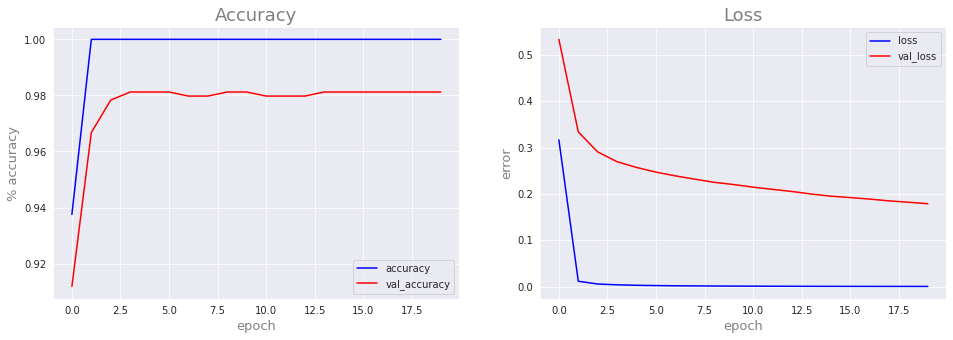

In [ ]:
model = Sequential()
model.add(Dense(400, input_dim = MW, activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(800, activation = 'sigmoid'))
model.add(Dense(6, activation = 'sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer = Adam(0.0002),\
              metrics = ['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=128,
                      validation_data=(x_test, y_test), verbose=1,
                      callbacks=lamCB)


###== API ==

### Доп проверка

Predict «Макс Фрай»::   0%|          | 0/209 [00:00<?, ?it/s]

Predict «Рэй Брэдберри»::   0%|          | 0/138 [00:00<?, ?it/s]

Predict «О. Генри»::   0%|          | 0/50 [00:00<?, ?it/s]

Predict «Клиффорд_Саймак»::   0%|          | 0/46 [00:00<?, ?it/s]

Predict «Булгаков»::   0%|          | 0/138 [00:00<?, ?it/s]

Predict «Стругацкие»::   0%|          | 0/111 [00:00<?, ?it/s]


Точность составила: 99.6%


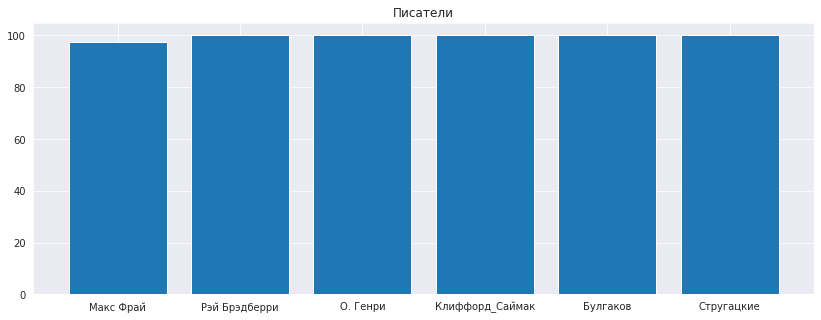

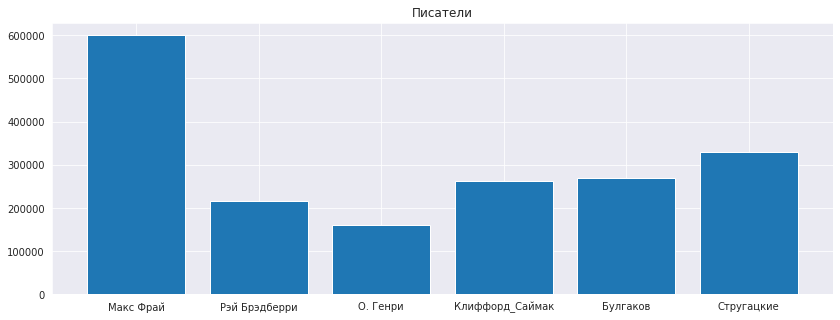

In [ ]:
def my_predict(a, z):
  counts = [np.argmax(model.predict(i[None, ...])) for i in tqdm_(a, desc=f'Predict «{ClassName[z]}»:')]
  maxCount = Counter(counts)
  maxC = maxCount.most_common()
  counts = np.array(counts)
  res = (counts[counts == z].shape[0] / counts.shape[0])*100
  res_text = f'{ClassName[z]}: точность = {round(res, 4)}% ===> AI определил как {ClassName[maxC[0][0]]}'
  return res_text, res

total = []
res_digit = []
for s in range(6):
  a = [x_test[i] for i in range(x_test.shape[0]) if np.argmax(y_test[i]) == s]
  a = np.array(a)
  res, r = my_predict(a,s)
  total.append(res)
  res_digit.append(r)
print()
print(f'Точность составила: {round(sum(res_digit)/ len(res_digit), 2)}%')
x = ClassName
y = res_digit
plt.figure(figsize=(14,5))
plt.bar(x, y, align='center')
plt.title('Писатели')
plt.show()
Writers()

In [ ]:
total

['Макс Фрай: точность = 97.6077% ===> AI определил как Макс Фрай',
 'Рэй Брэдберри: точность = 100.0% ===> AI определил как Рэй Брэдберри',
 'О. Генри: точность = 100.0% ===> AI определил как О. Генри',
 'Клиффорд_Саймак: точность = 100.0% ===> AI определил как Клиффорд_Саймак',
 'Булгаков: точность = 100.0% ===> AI определил как Булгаков',
 'Стругацкие: точность = 100.0% ===> AI определил как Стругацкие']

In [ ]:
model.save('/content/drive/MyDrive/Базы/Writers_9928.h5')